In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns

π=np.pi
G=4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c=0.3068                #in units of pc yr^-1
ρ_eq=3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t=13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
yr=3.154e7             # in units of seconds



k=19.4965 
σ_eq=0.005
ρ_m=4e19             #ρ_m=4e19 M☉ Gpc^-3


m_1=6
m_2=8

y_1=math.log(m_1)
y_2=math.log(m_2)
dy=(y_2-y_1)


y_list=np.zeros(10)

for i in range(len(y_list)):
    y_list[i]= (y_1+(i*dy))
    

M_1_list=np.zeros(len(y_list))
M_2_list=np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i]=(math.ceil(math.exp(y)))
    M_2_list[i]=(math.ceil(math.exp(y)))
    

            
m_1_list=[int(M_1) for M_1 in M_1_list]
m_2_list=[int(M_2) for M_2 in M_2_list]

    
Δ_1_list=np.zeros(len(y_list))
Δ_2_list=np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = math.exp(y + 0.5*dy)-math.exp(y - 0.5*dy)
    Δ_2_list[i] = math.exp(y + 0.5*dy)-math.exp(y - 0.5*dy) 
        

In [2]:
A=((ρ_eq**(4/3))*(G**3)*(k**7))/(c**5)


def merger_rate(m_1,m_2,Δ_1,Δ_2,t):
    def f_(f,m):
        return f*P(m)
    
    def f_b(f,m_1,m_2):
        return  f_(f,m_1)+f_(f,m_2)
    
    def μ(f,m_1,m_2):
        return   (2*m_1*m_2*f_b(f,m_1,m_2))/((m_1+m_2)*(f_(f,m_2)*m_1+f_(f,m_1)*m_2))

    
    def B(m_1,m_2,f):
        return (A**(1/7)) * ((m_1*m_2*t*((m_1+m_2)**(-1/3)))**(1/7))* ((f**2 + 1.2009*(σ_eq**2))**(-1/2)) *((f_b(f,m_1,m_2))**(37/21))
    
    def D(m_1,m_2,f):
        return (B(m_1,m_2,f)**(21/37))/(f_b(f,m_1,m_2))  
    
    def γ_X(Y,m_1,m_2,f):      #eq.(12) in the notes.
        return (((1 + 0.1709 * D(m_1,m_2,f) * (Y**(-21/37)))**(-1/14))/( 1 + 0.0136 * D(m_1,m_2,f) * (Y**(-21/37))))*Y

    def PDF(m):
        return (P(m)/m)

    I = quad(PDF, 5, 100)  # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                               # 0 to infinity.
    
    n_T = f*ρ_eq*I[0]         #n_T=f*ρ_eq∫(P(m)/m)*dm 
   
    def x̄(f,m_1,m_2):
        return ((3*(m_1+m_2))/(8*π*ρ_eq*f_b(f,m_1,m_2)))**(1/3)
    
    Y=np.linspace(1e-2,1e10,1000000) 
    
    def integrand(Y,m_1,m_2,f):
        return (Y**(-58/37)) * math.exp(-((4*π)/3)*(x̄(f,m_1,m_2)**(3))*n_T) * ((γ_X(Y,m_1,m_2,f)**2)/ ((1 + γ_X(Y,m_1,m_2,f)**2)**(3/2)))
    
    f2=np.vectorize(integrand) 
    
    return (3/74)* (A**(3/37)) * ρ_m * (f**2) *(t**(-34/37))* ((f**2 + 1.2009*(σ_eq**2))**(-21/74)) * min((P(m_1*Δ_1))/m_1, (P(m_2*Δ_2))/m_2) * ((P(m_1*Δ_1))/m_1 + (P(m_2*Δ_2))/m_2) * (m_1*m_2)**(3/37) * (m_1+m_2)**(36/37)* (np.trapz(f2(Y,m_1,m_2,f),Y))



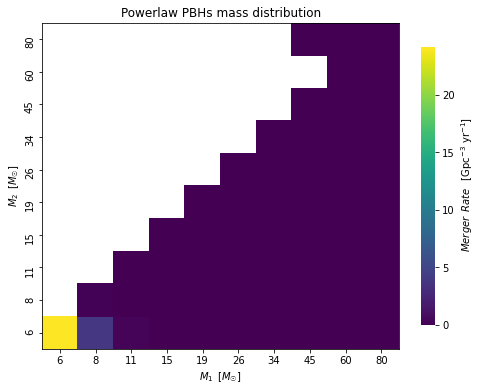

In [3]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2 with Δ_1=Δ_2=Δ.



f_pbh = 4.3e-3
f = 0.85*f_pbh
     
def P(m): #Powerlaw PBH mass distribution
    α = 1.6
    M = 5     #in units of kg
    return (α-1)/M * ((m/M)**(-α))


Merge = np.zeros((10, 10))



for i in range(10):
    for j in range(10):
        if i==j:
            Merge[i:(i+1), j:(j+1)] = 0.5*merger_rate(m_1_list[i], m_2_list[j],Δ_1_list[i],Δ_1_list[j],t)
            
        else:
            Merge[i:(i+1), j:(j+1)] = merger_rate(m_1_list[i], m_2_list[j],Δ_1_list[i],Δ_1_list[j],t)   
    
        


mask = np.tril(Merge,k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(8, 6))  

ax = sns.heatmap(Merge, mask=mask,  cmap='viridis', cbar=True, 
                 cbar_kws={"shrink": 0.85,'label': ' $Merger\hspace{0.5}Rate \hspace{0.5}$ [Gpc$^{-3}$ yr$^{-1}$]'},
                 vmin=0, xticklabels = m_1_list, yticklabels = m_2_list)





# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)

ax.invert_yaxis()
plt.xlabel('$M_{1}\hspace{0.5}[M_{☉}]$')
plt.ylabel('$M_{2}\hspace{0.5}[M_{☉}]$')
plt.title('Powerlaw PBHs mass distribution')
plt.savefig('Merger rate for Powerlaw PDF.pdf')
plt.show()     

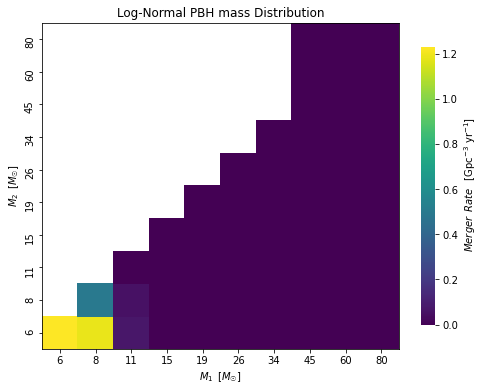

In [4]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2 with Δ_1=Δ_2=Δ.


f_pbh = 4.3e-3
f = 0.85*f_pbh 

def P(m):               #Log-Normal PBH mass Distribution
    σ=0.6
    m_c=15               #in units of M☉
    return  math.exp(-((math.log(m/m_c))**2)/(2*(σ**2)))/(σ*m*math.sqrt(2*π))



Merger = np.zeros((10, 10))


for i in range(10):
    for j in range(10):
        if i==j:
            Merger[i:(i+1), j:(j+1)] = 0.5*merger_rate(m_1_list[i], m_2_list[j],Δ_1_list[i],Δ_1_list[j],t)
            
        else:
            Merger[i:(i+1), j:(j+1)] = merger_rate(m_1_list[i], m_2_list[j],Δ_1_list[i],Δ_1_list[j],t)
            



mask = np.tril(Merger,k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(8, 6))  

ax = sns.heatmap(Merger, mask=mask,  cmap='viridis', cbar=True,
                 cbar_kws={"shrink": 0.85,'label': ' $Merger\hspace{0.5}Rate \hspace{0.5}$ [Gpc$^{-3}$ yr$^{-1}$]'},
                 vmin=0, xticklabels = m_1_list, yticklabels = m_2_list)


# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)


    
ax.invert_yaxis()
plt.xlabel('$M_{1}\hspace{0.5}[M_{☉}]$')
plt.ylabel('$M_{2}\hspace{0.5}[M_{☉}]$')
plt.title('Log-Normal PBH mass Distribution')
plt.savefig('Merger rate for Log-Normal PDF.pdf')
plt.show()     